1. Deciding on the YOLO model based on human detection accuracy


In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)

# Validate the model
metrics = model.val(data='Dataset_humans/humans.yaml')  # no arguments needed, dataset and settings remembered
# metrics.box.map    # map50-95
# metrics.box.map50  # map50
# metrics.box.map75  # map75
# metrics.box.maps   # a list contains map50-95 of each category

In [15]:
metrics.box.maps

array([    0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,
           0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,
           0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,     0.32548,
           0.32548,     0.32548,     0.3254

FPS Analysis

In [4]:
import subprocess
import numpy as np
import matplotlib.pyplot as plt


In [5]:
def hyperparameters_analysis(save_frames='no', detection_confidence = [0.5, 0.7, 0.9], num_saved_images = [10, 20, 40], verification_time = [1, 2, 3], threshold_coefficient = [0.5, 0.7, 0.9]):
    # Define the default hyperparameters
    default_hyperparameters = {
        'method': 'osnet',
        'detection_confidence': 0.8 if len(detection_confidence)> 1 else detection_confidence[0],
        'num_saved_images': 30 if len(num_saved_images)> 1 else num_saved_images[0],
        'verification_time': 1 if len(verification_time)> 1 else verification_time[0],
        'threshold_coefficient': 0.8 if len(threshold_coefficient)> 1 else threshold_coefficient[0],
    }

    # Define the hyperparameters to test
    test_hyperparameters = {
        'detection_confidence': detection_confidence,
        'num_saved_images': num_saved_images,
        'verification_time': verification_time,
        'threshold_coefficient': threshold_coefficient
    }
    # remove hyperparameters that have only one value in the list because they are default hyperparameters then
    for hp_name, hp_values in list(test_hyperparameters.items()):
        if len(hp_values) == 1:
            del test_hyperparameters[hp_name]
    
    if save_frames != 'no':
        default_hyperparameters['save_frames'] = 'yes'  # Update save_images in hyperparameters if it is not None

    # Define the videos to test
    input_videos = ['test_videos/test_video1.mp4', 'test_videos/test_video2.mp4', 'test_videos/test_video3.mp4', 'test_videos/test_video4.mp4']

    # Initialize result lists
    hyperparameters = []
    fps_values = []

    # Iterate through all combinations of hyperparameters and videos
    for hp_name, hp_values in test_hyperparameters.items():
        for hp_value in hp_values:
            for input_video in input_videos:
                # Construct the command to run the script with current hyperparameters
                command = [
                    'python', 'main.py',
                    '-method', default_hyperparameters['method'],
                    '-detection_confidence', str(default_hyperparameters['detection_confidence']),
                    '-num_saved_images', str(default_hyperparameters['num_saved_images']),
                    '-verification_time', str(default_hyperparameters['verification_time']),
                    '-threshold_coefficient', str(default_hyperparameters['threshold_coefficient']),
                    '-input_video', input_video
                ]
                if save_frames != 'no':
                    command.extend(['-save_frames', default_hyperparameters['save_frames']])  # Add save_images flag to command if it is not 

                # Update the specific hyperparameter under test
                command[2 * (list(default_hyperparameters.keys()).index(hp_name) + 1) + 1] = str(hp_value)

                # Execute the command and capture the output
                output = subprocess.check_output(command, universal_newlines=True)

                # Parse the output to extract FPS value
                fps_line = [line for line in output.split('\n') if line.startswith('FPS:')]
                if fps_line:
                    print(fps_line)
                    fps_str = fps_line[0].split(':')[1].strip()
                    fps_str = fps_str.rstrip('.')  # Remove trailing period, if present
                    fps = float(fps_str)
                    print(f'Hyperparameters: {default_hyperparameters}')
                    print(f'FPS: {fps}\n')

                    # Store the hyperparameters and FPS value
                    hyperparameters.append((hp_name, hp_value))
                    fps_values.append(fps)

    # Convert fps_values and hyperparameters to numpy arrays
    fps_values = np.array(fps_values)
    hyperparameters = np.array(hyperparameters)

    # Calculate average FPS for each set of hyperparameters
    fps_values_avg = np.zeros(len(fps_values) // len(input_videos))
    hyperparameters_avg = hyperparameters[::len(input_videos)]

    for i in range(len(fps_values) // len(input_videos)):
        fps_values_avg[i] = np.mean(fps_values[i * len(input_videos):(i+1) * len(input_videos)])

    # Update fps_values and hyperparameters with their averaged versions
    fps_values = fps_values_avg
    hyperparameters = hyperparameters_avg
    return fps_values, hyperparameters


In [12]:
def plot_fps_hyperparameters(fps_values, hyperparameters):
    # Convert hyperparameters to a numpy array for easy slicing
    hyperparameters = np.array(hyperparameters)

    # Numerical hyperparameters
    numerical_hyperparams_indices = [0]
    numerical_hyperparams_names = ['detection_confidence', 'num_saved_images', 'verification_time', 'threshold_coefficient']

    for index, name in enumerate(numerical_hyperparams_names):
        # Get the fps and hyperparameters related to the current hyperparameter
        mask = np.array([hp[0] for hp in hyperparameters]) == name
        current_hyperparam_fps = np.array(fps_values)[mask]
        current_hyperparam_values = np.array([hp[1] for hp in hyperparameters if hp[0] == name])
        
        # Check if there are any values to plot for the current hyperparameter
        if len(current_hyperparam_fps) > 0:
            plt.figure(figsize=(12, 6))
            
            # Sort the values for coherent line plot
            sorted_indices = np.argsort(current_hyperparam_values)
            
            plt.plot(current_hyperparam_values[sorted_indices], current_hyperparam_fps[sorted_indices], label='osnet', marker='o')
            plt.xlabel(name)
            plt.ylabel('FPS')
            plt.title(f'FPS vs {name}')
            plt.legend()
            plt.grid(True)
            plt.show()


In [ ]:
fps_values, hyperparameters = hyperparameters_analysis()

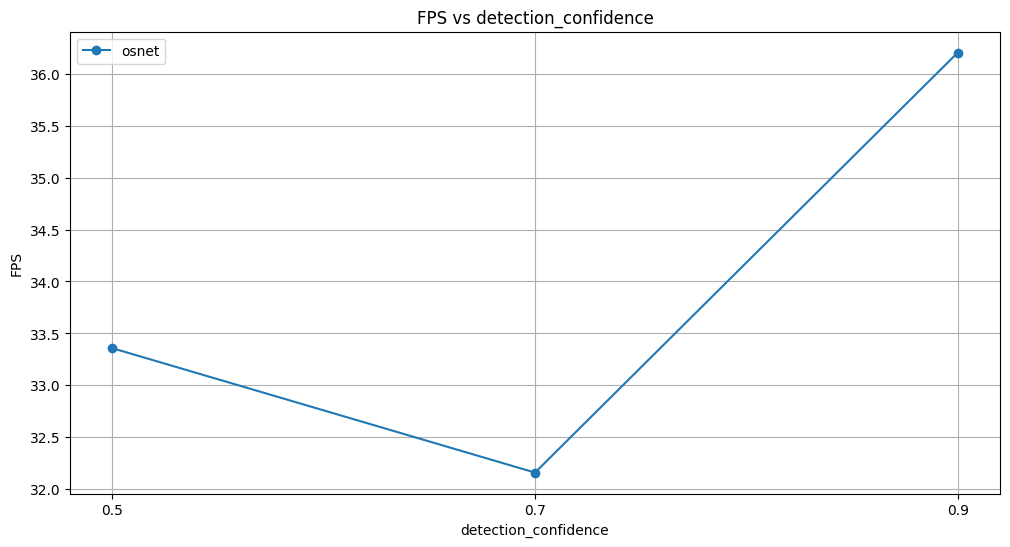

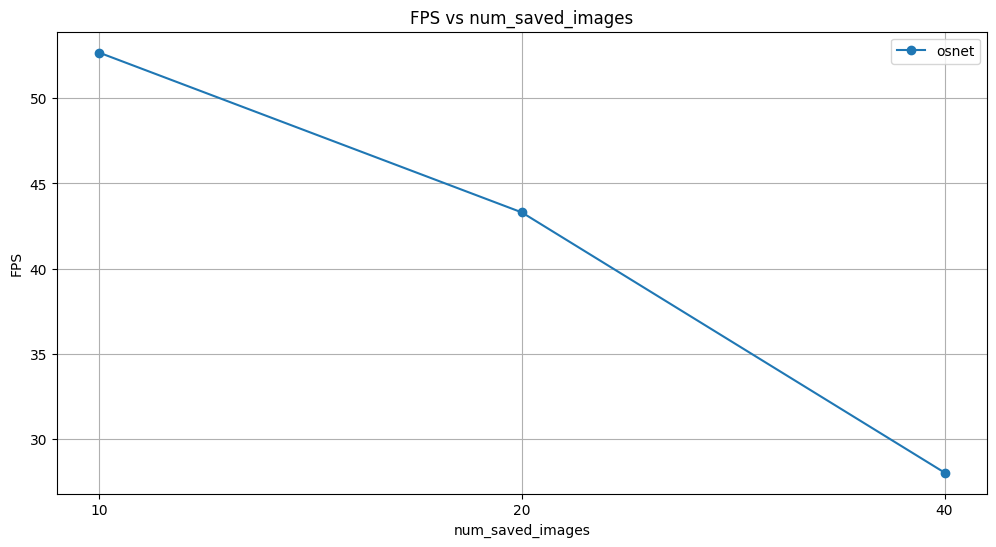

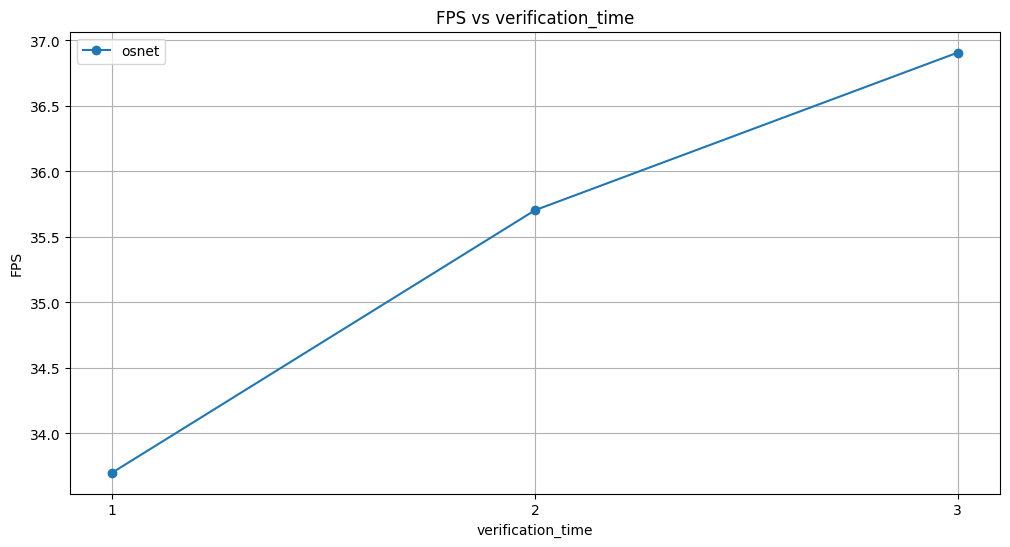

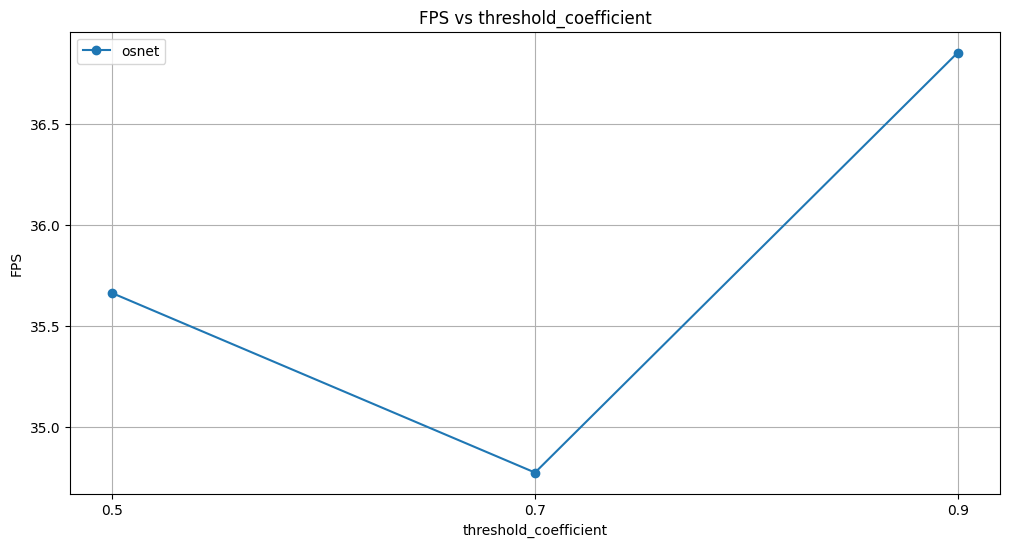

In [13]:
plot_fps_hyperparameters(fps_values, hyperparameters)

Identification Analysis

In [6]:
fps_values, hyperparameters = hyperparameters_analysis(save_frames = True, verification_time=[0.3])

['FPS: 10.761308424267925.']
Hyperparameters: {'method': 'osnet', 'detection_confidence': 0.8, 'num_saved_images': 30, 'verification_time': 0.3, 'threshold_coefficient': 0.8, 'save_frames': 'yes'}
FPS: 10.761308424267925

['FPS: 28.71745947918667.']
Hyperparameters: {'method': 'osnet', 'detection_confidence': 0.8, 'num_saved_images': 30, 'verification_time': 0.3, 'threshold_coefficient': 0.8, 'save_frames': 'yes'}
FPS: 28.71745947918667

['FPS: 16.751106510477353.']
Hyperparameters: {'method': 'osnet', 'detection_confidence': 0.8, 'num_saved_images': 30, 'verification_time': 0.3, 'threshold_coefficient': 0.8, 'save_frames': 'yes'}
FPS: 16.751106510477353

['FPS: 21.61601599555984.']
Hyperparameters: {'method': 'osnet', 'detection_confidence': 0.8, 'num_saved_images': 30, 'verification_time': 0.3, 'threshold_coefficient': 0.8, 'save_frames': 'yes'}
FPS: 21.61601599555984

['FPS: 22.53459355217343.']
Hyperparameters: {'method': 'osnet', 'detection_confidence': 0.8, 'num_saved_images': 30

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the directory containing the text files
txt_dir = 'ID_results/test_video1/'

# Initialize lists to store detection confidences and accuracies
detection_confidences = []
accuracies = []

# Get a list of all text files
txt_files = [f for f in os.listdir(txt_dir) if f.endswith('.txt') and not f.endswith('_CORRECT.txt')]

# Loop over each file
for file_name in txt_files:
    # Check if file name follows expected format
    if 'd' in file_name and '_' in file_name:
        # Construct the name of the corresponding _CORRECT.txt file
        correct_file_name = file_name + '_CORRECT.txt'
        
        # Open the file and read its contents
        with open(os.path.join(txt_dir, file_name), 'r') as file:
            results = file.read().splitlines()
        
        # Open the correct results file and read its contents
        with open(os.path.join(txt_dir, correct_file_name), 'r') as file:
            correct_results = file.read().splitlines()
        
        # Calculate accuracy (percentage of matching entries)
        matching_results = [i for i, j in zip(results, correct_results) if i == j]
        accuracy = len(matching_results) / len(results)
        accuracies.append(accuracy)
        
        # Extract detection confidence from file name and convert it to float
        detection_confidence = float(file_name.split('d')[1].split('_')[0])
        detection_confidences.append(detection_confidence)

# Plot detection confidence vs accuracy
plt.figure(figsize=(10, 6))
plt.plot(detection_confidences, accuracies, 'o-')
plt.title('Detection Confidence vs Accuracy')
plt.xlabel('Detection Confidence')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'ID_results/test_video1/d0.5_num30_t0.3_thr0.8.txt_CORRECT.txt'

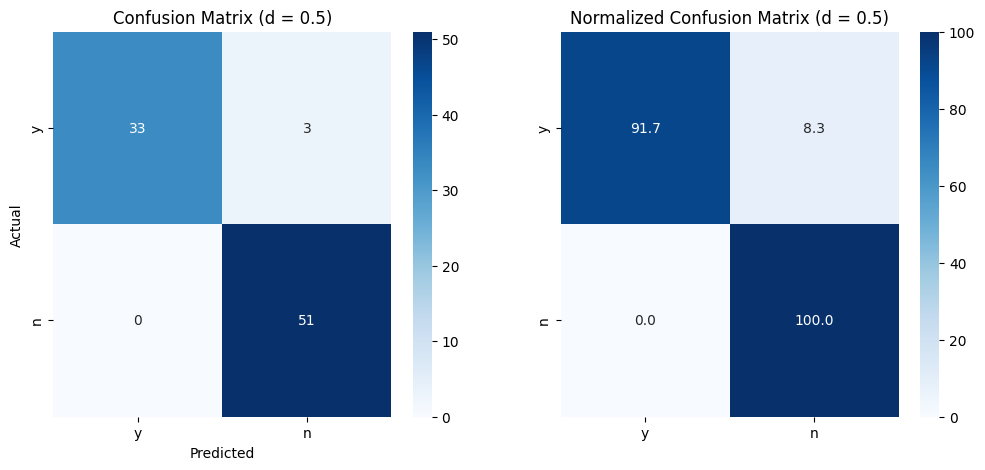

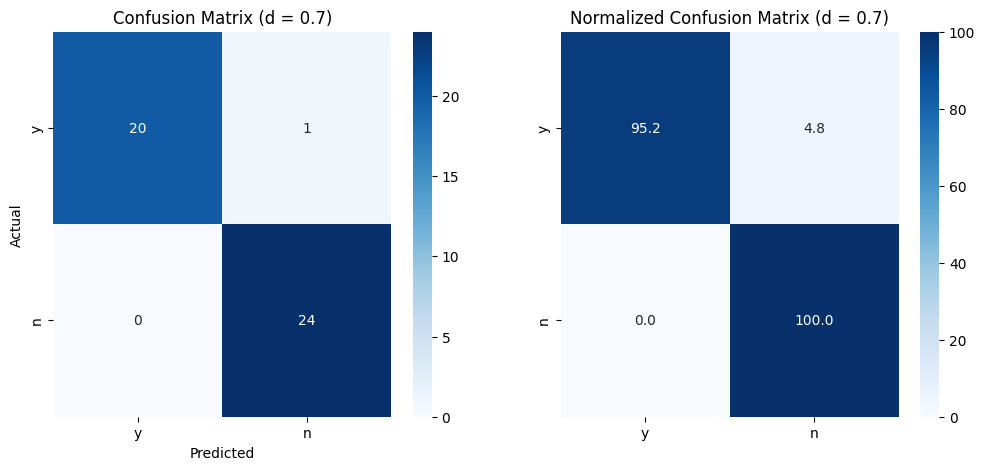

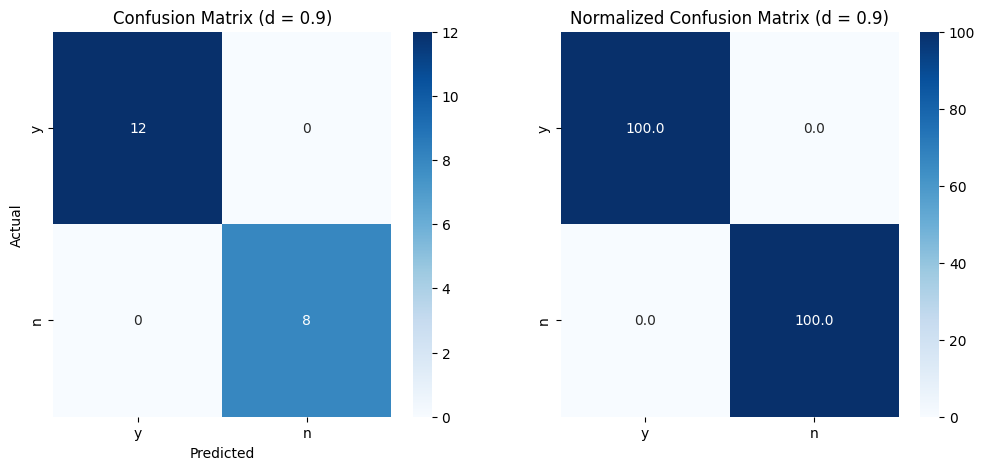

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import defaultdict

# Define the directory containing the text files
txt_dir = 'ID_results/test_video1'

# List all files in directory
txt_files = os.listdir(txt_dir)

# Initialize defaultdict of confusion matrices
confusion_matrices = defaultdict(lambda: np.zeros((2, 2)))

# Default values for other hyperparameters
default_num = 30
default_thr = 0.8

# Loop over each file
for file_name in txt_files:
    # Check if file name follows expected format
    if 'd' in file_name and '_' in file_name and not file_name.endswith('_CORRECT.txt'):
        # Extract hyperparameters from file name
        params = file_name.split('d')[1].split('_')
        detection_confidence = float(params[0])
        num = int(params[1].replace('num', ''))
        thr = float(params[3].replace('thr', '').replace('.txt', ''))


        # Check if other hyperparameters are at their default values
        if num == default_num and thr == default_thr:
            # Construct the name of the corresponding _CORRECT.txt file
            correct_file_name = file_name.rstrip('.txt') + '_CORRECT.txt'

            # Open the file and read its contents
            with open(os.path.join(txt_dir, file_name), 'r') as file:
                results = file.read().splitlines()

            # Open the correct results file and read its contents
            with open(os.path.join(txt_dir, correct_file_name), 'r') as file:
                correct_results = file.read().splitlines()

            # Count TP, TN, FP, and FN
            for i, j in zip(results, correct_results):
                if i == 'y' and j == 'y':
                    confusion_matrices[detection_confidence][0, 0] += 1
                elif i == 'y' and j == 'n':
                    confusion_matrices[detection_confidence][0, 1] += 1
                elif i == 'n' and j == 'y':
                    confusion_matrices[detection_confidence][1, 0] += 1
                elif i == 'n' and j == 'n':
                    confusion_matrices[detection_confidence][1, 1] += 1

# Plot the confusion matrices for each detection confidence
for detection_confidence, conf_mat in confusion_matrices.items():
    plt.figure(figsize=(12, 5))

    plt.subplot(121)
    conf_mat = conf_mat.astype(int)  # Cast to int before plotting
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues', xticklabels=['y', 'n'], yticklabels=['y', 'n'])
    plt.title(f'Confusion Matrix (d = {detection_confidence})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.subplot(122)
    norm_conf_mat = conf_mat / conf_mat.sum(axis=1, keepdims=True) * 100  # Normalized matrix as percentage
    sns.heatmap(norm_conf_mat, annot=True, fmt=".1f", cmap='Blues', xticklabels=['y', 'n'], yticklabels=['y', 'n'])  # Show one decimal place
    plt.title(f'Normalized Confusion Matrix (d = {detection_confidence})')
    plt.xlabel


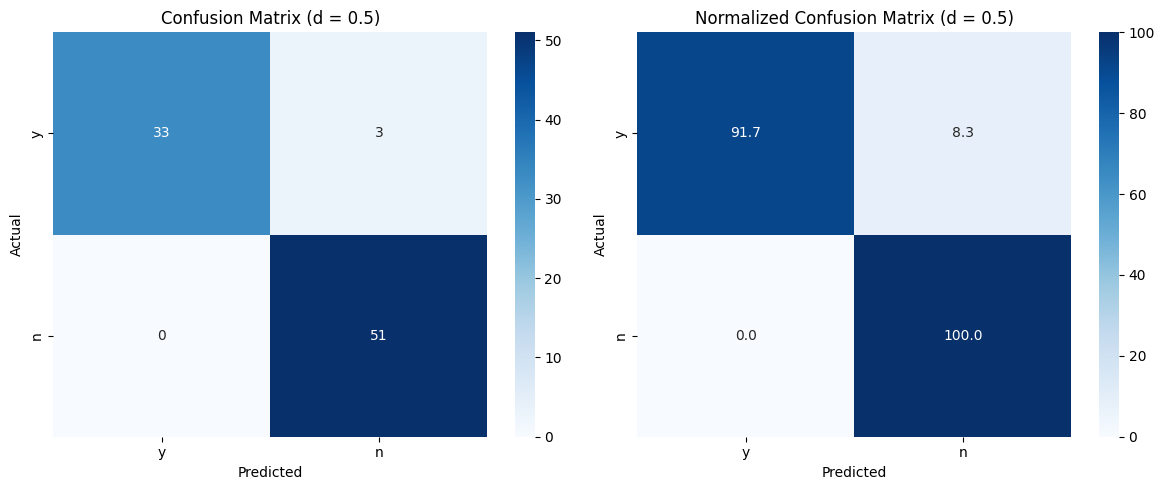

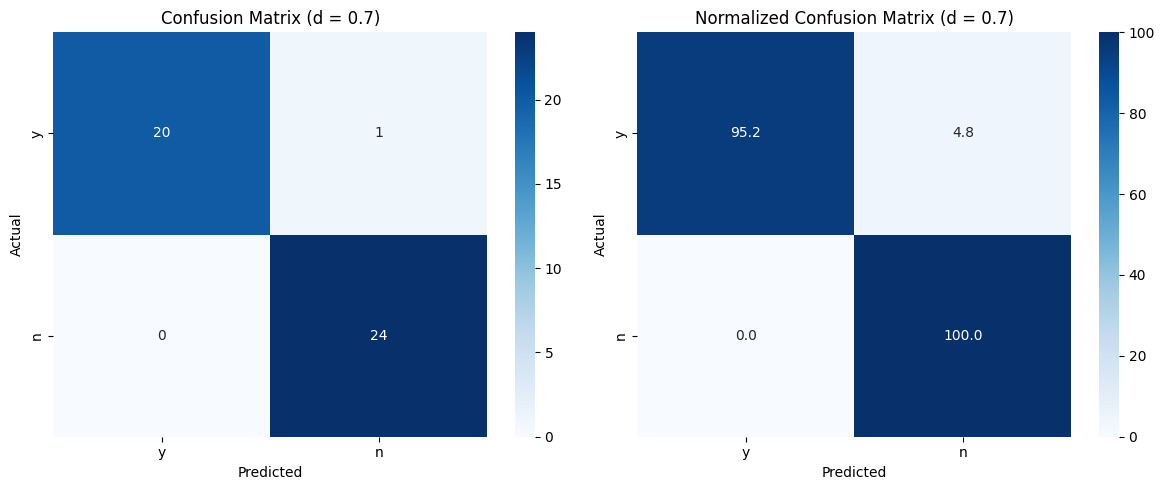

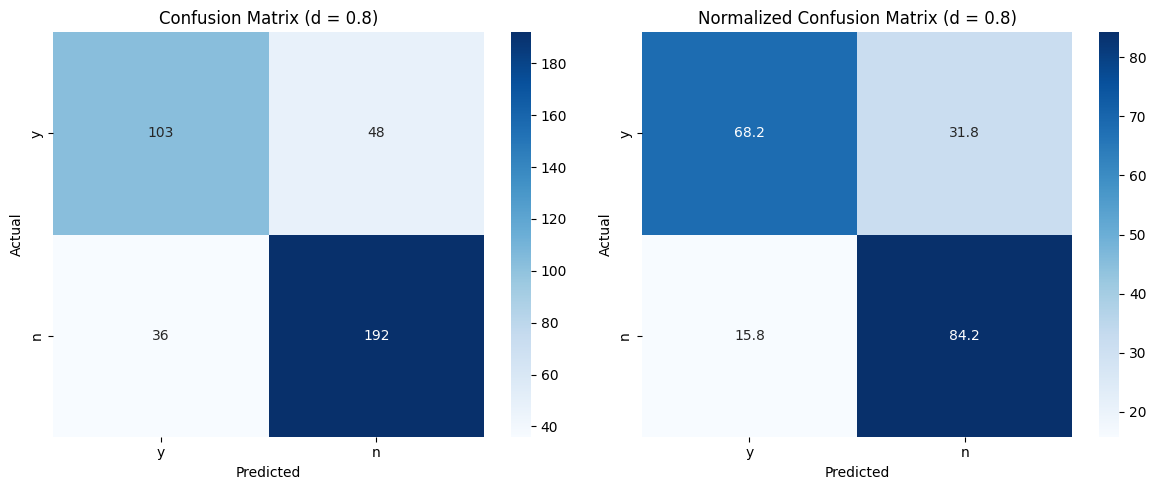

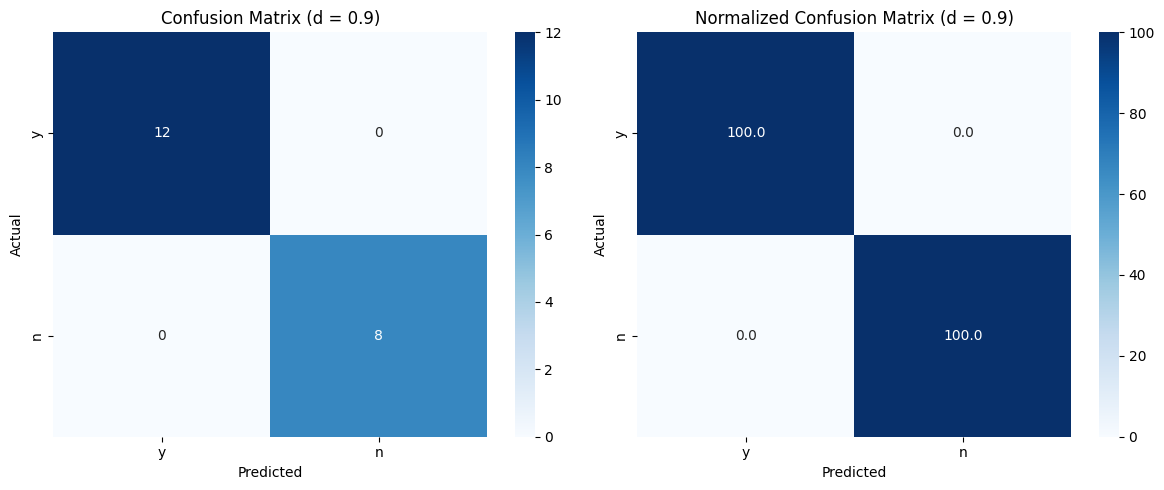

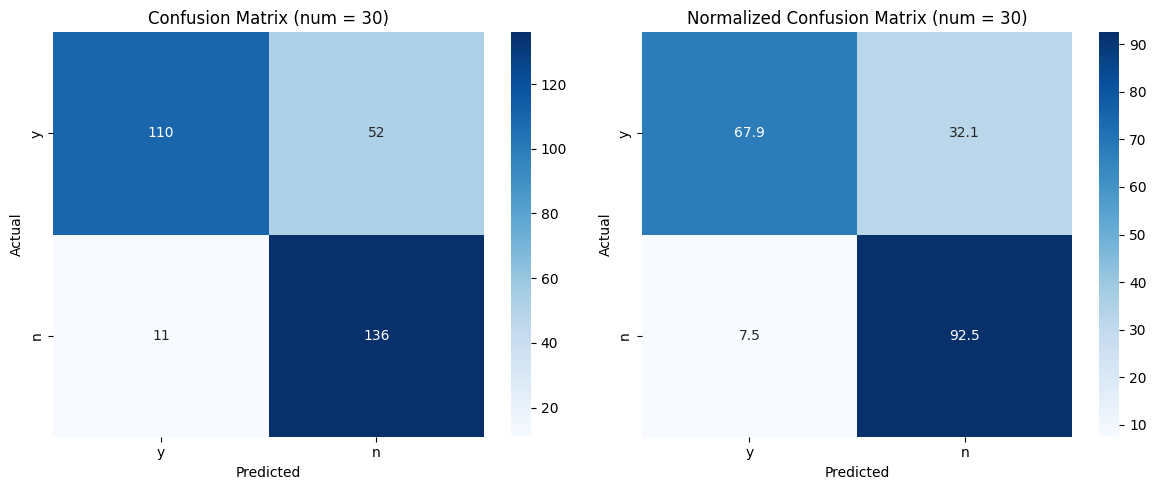

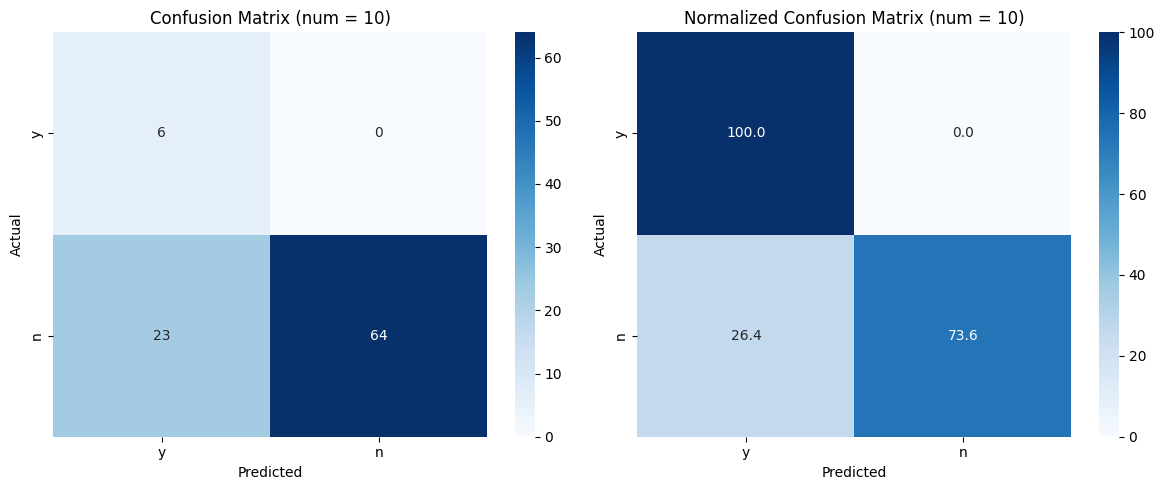

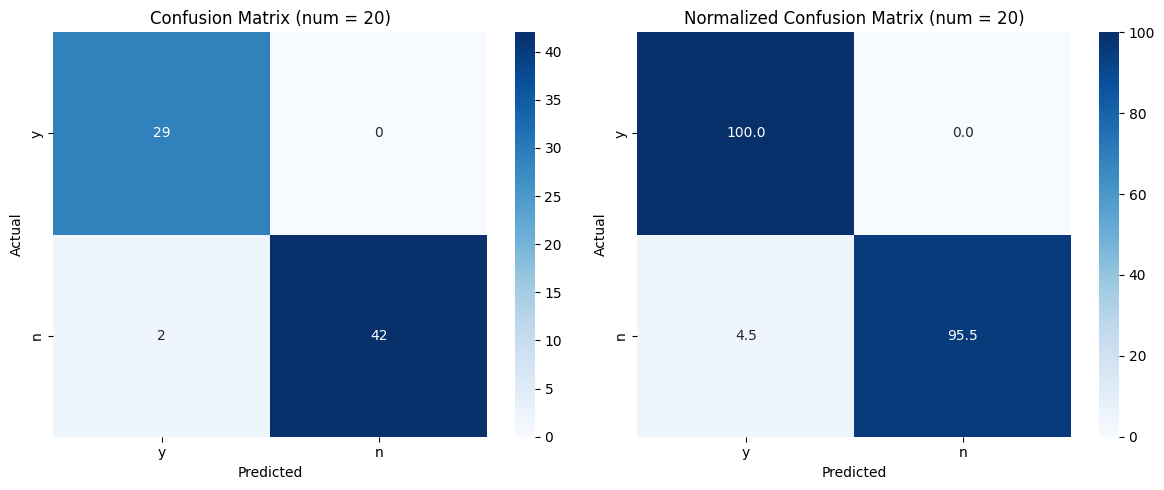

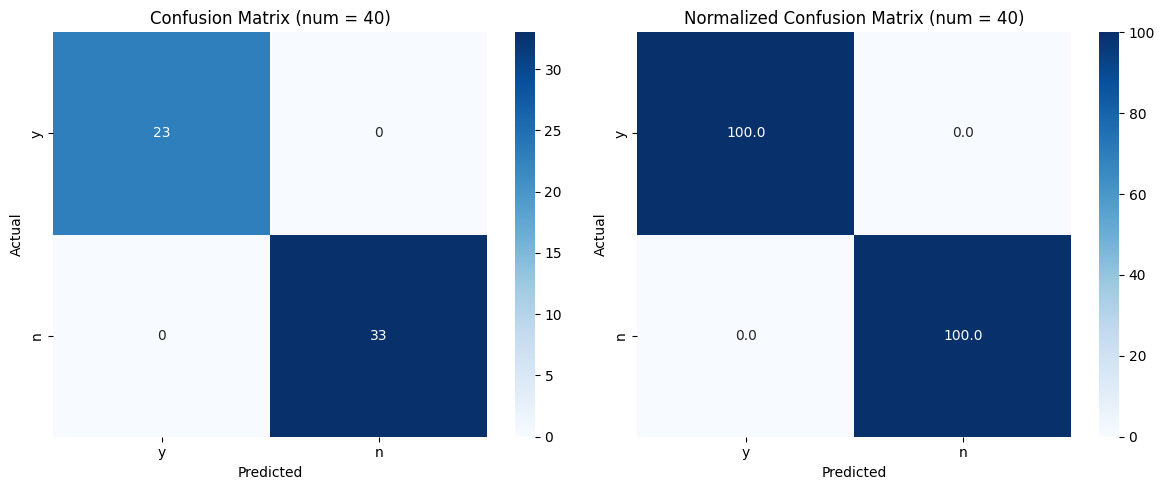

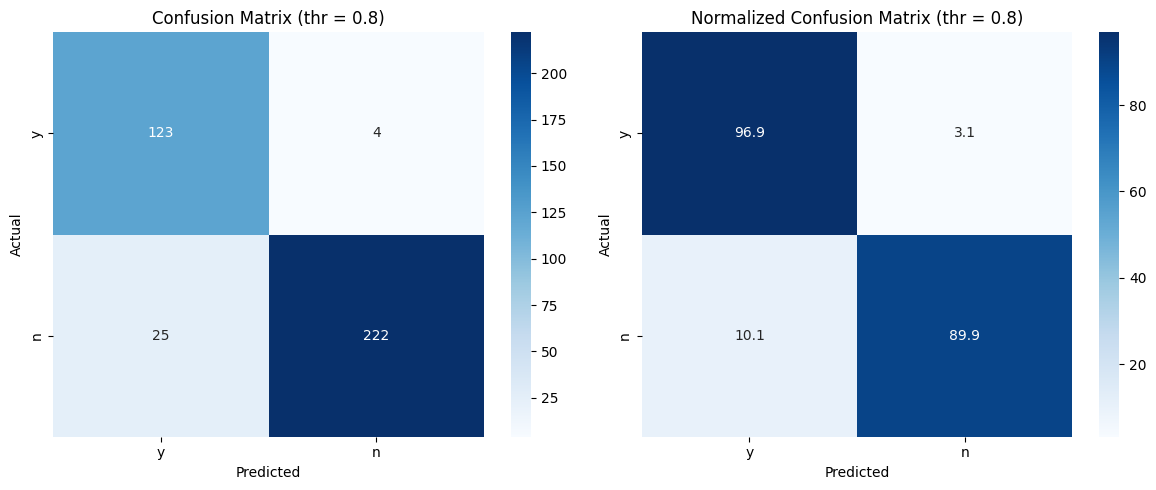

C:\Users\justa\AppData\Local\Temp\ipykernel_41052\3570051858.py:61: RuntimeWarning: invalid value encountered in divide
  norm_conf_mat = conf_mat / conf_mat.sum(axis=1, keepdims=True) * 100  # Normalized matrix as percentage


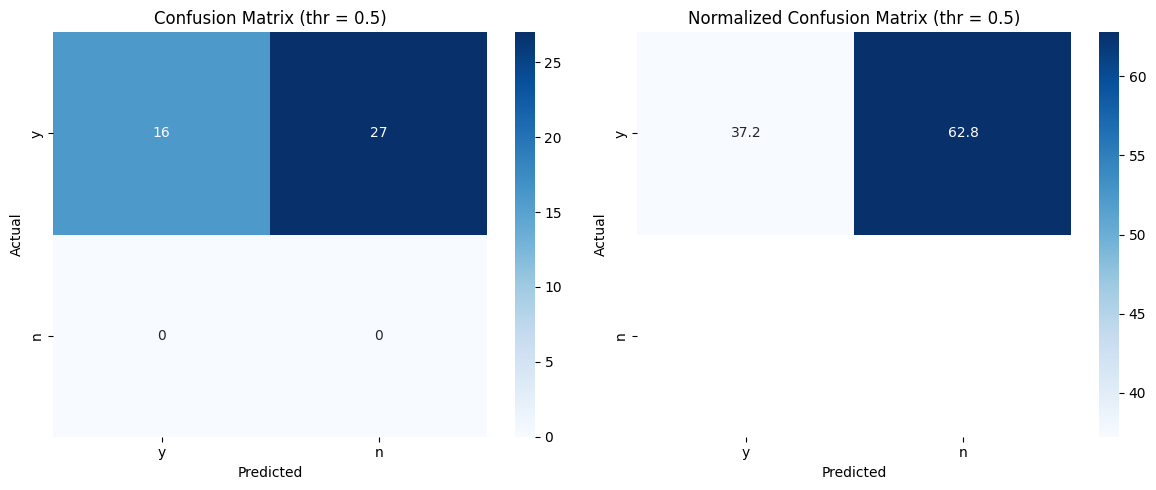

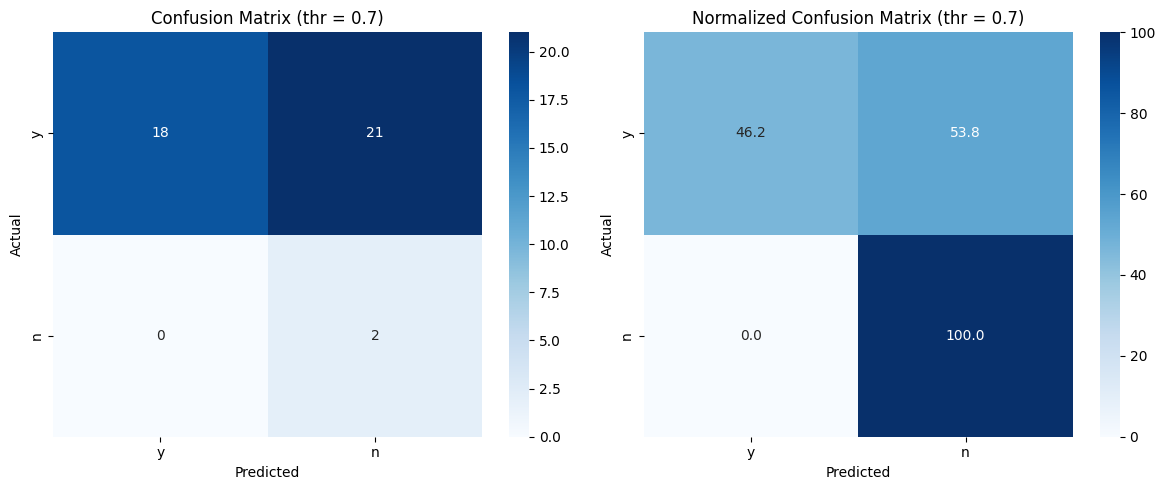

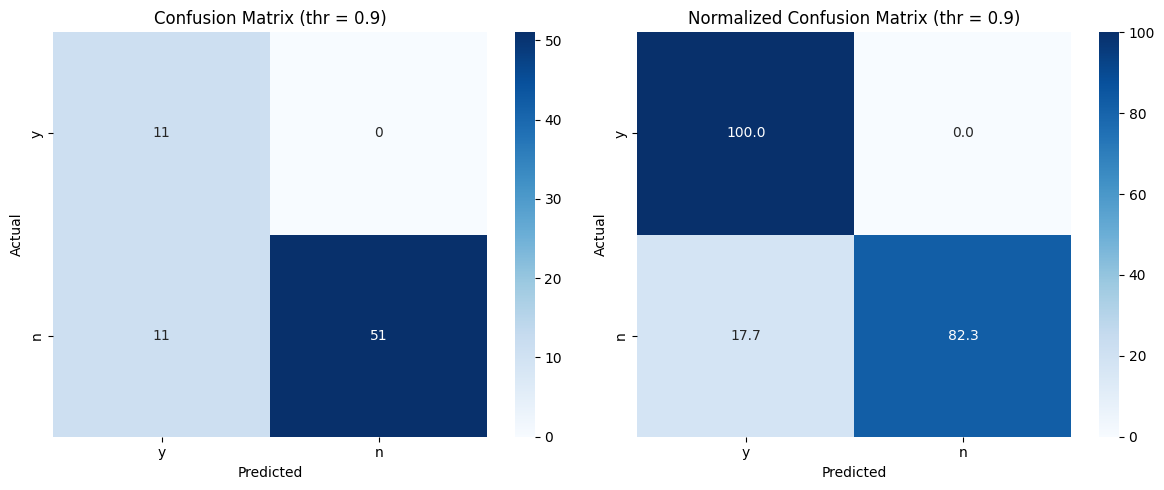

In [29]:
# Initialize defaultdict of confusion matrices for each hyperparameter
d_confusion_matrices = defaultdict(lambda: np.zeros((2, 2)))
num_confusion_matrices = defaultdict(lambda: np.zeros((2, 2)))
thr_confusion_matrices = defaultdict(lambda: np.zeros((2, 2)))

# Loop over each file
for file_name in txt_files:
    # Check if file name follows expected format
    if 'd' in file_name and '_' in file_name and not file_name.endswith('_CORRECT.txt'):
        # Extract hyperparameters from file name
        params = file_name.split('d')[1].split('_')
        detection_confidence = float(params[0])
        num = int(params[1].replace('num', ''))
        thr = float(params[3].replace('thr', '').replace('.txt', ''))

        # Construct the name of the corresponding _CORRECT.txt file
        correct_file_name = file_name.rstrip('.txt') + '_CORRECT.txt'

        # Open the file and read its contents
        with open(os.path.join(txt_dir, file_name), 'r') as file:
            results = file.read().splitlines()

        # Open the correct results file and read its contents
        with open(os.path.join(txt_dir, correct_file_name), 'r') as file:
            correct_results = file.read().splitlines()

        # Count TP, TN, FP, and FN
        for i, j in zip(results, correct_results):
            if i == 'y' and j == 'y':
                d_confusion_matrices[detection_confidence][0, 0] += 1
                num_confusion_matrices[num][0, 0] += 1
                thr_confusion_matrices[thr][0, 0] += 1
            elif i == 'y' and j == 'n':
                d_confusion_matrices[detection_confidence][0, 1] += 1
                num_confusion_matrices[num][0, 1] += 1
                thr_confusion_matrices[thr][0, 1] += 1
            elif i == 'n' and j == 'y':
                d_confusion_matrices[detection_confidence][1, 0] += 1
                num_confusion_matrices[num][1, 0] += 1
                thr_confusion_matrices[thr][1, 0] += 1
            elif i == 'n' and j == 'n':
                d_confusion_matrices[detection_confidence][1, 1] += 1
                num_confusion_matrices[num][1, 1] += 1
                thr_confusion_matrices[thr][1, 1] += 1

# Plot the confusion matrices for each hyperparameter
for hyperparameter, matrices in [("d", d_confusion_matrices), 
                                 ("num", num_confusion_matrices), 
                                 ("thr", thr_confusion_matrices)]:
    for value, conf_mat in matrices.items():
        plt.figure(figsize=(12, 5))

        plt.subplot(121)
        conf_mat = conf_mat.astype(int)  # Cast to int before plotting
        sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues', xticklabels=['y', 'n'], yticklabels=['y', 'n'])
        plt.title(f'Confusion Matrix ({hyperparameter} = {value})')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        plt.subplot(122)
        norm_conf_mat = conf_mat / conf_mat.sum(axis=1, keepdims=True) * 100  # Normalized matrix as percentage
        sns.heatmap(norm_conf_mat, annot=True, fmt=".1f", cmap='Blues', xticklabels=['y', 'n'], yticklabels=['y', 'n'])  # Show one decimal place
        plt.title(f'Normalized Confusion Matrix ({hyperparameter} = {value})')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        plt.tight_layout()
        plt.show()


C:\Users\justa\AppData\Local\Temp\ipykernel_41052\3978108730.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


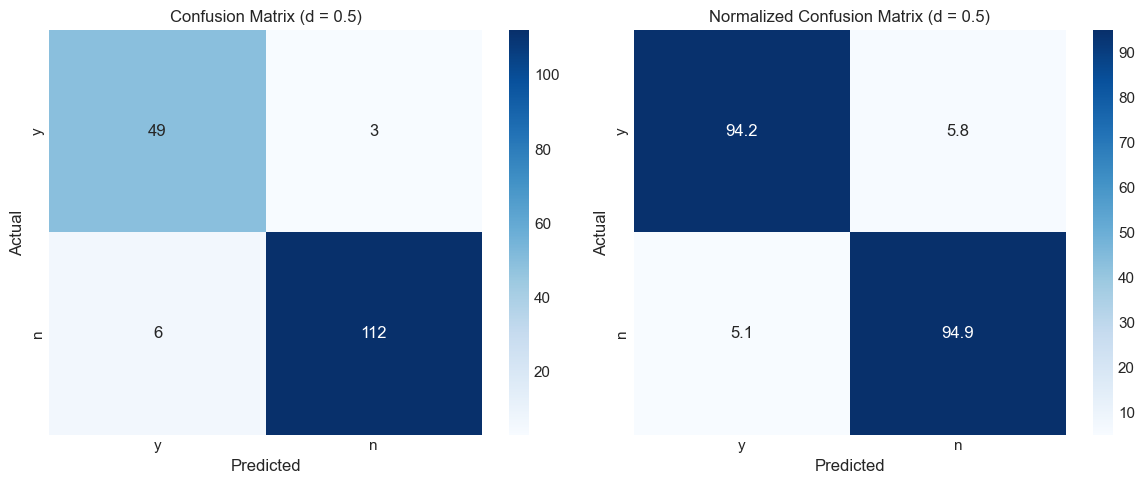

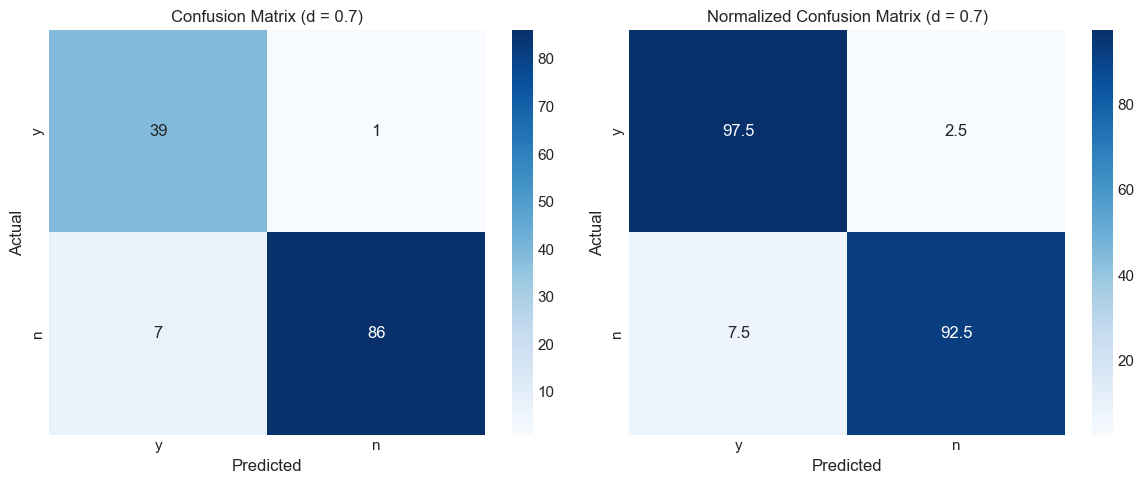

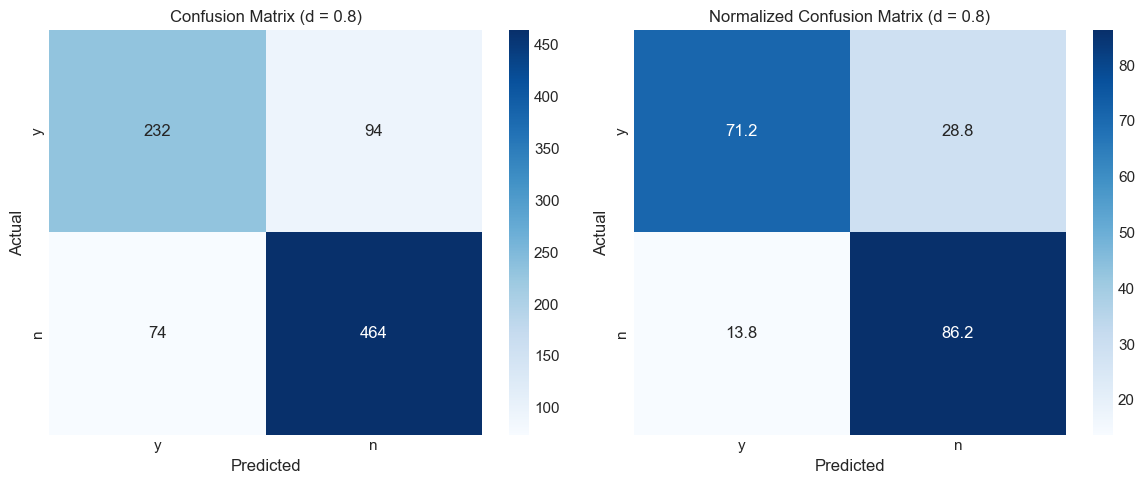

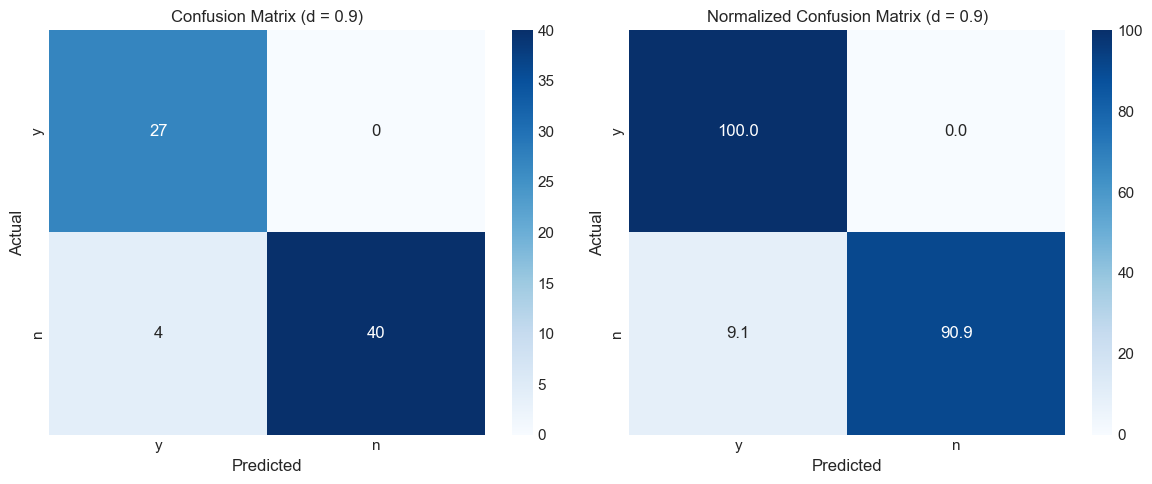

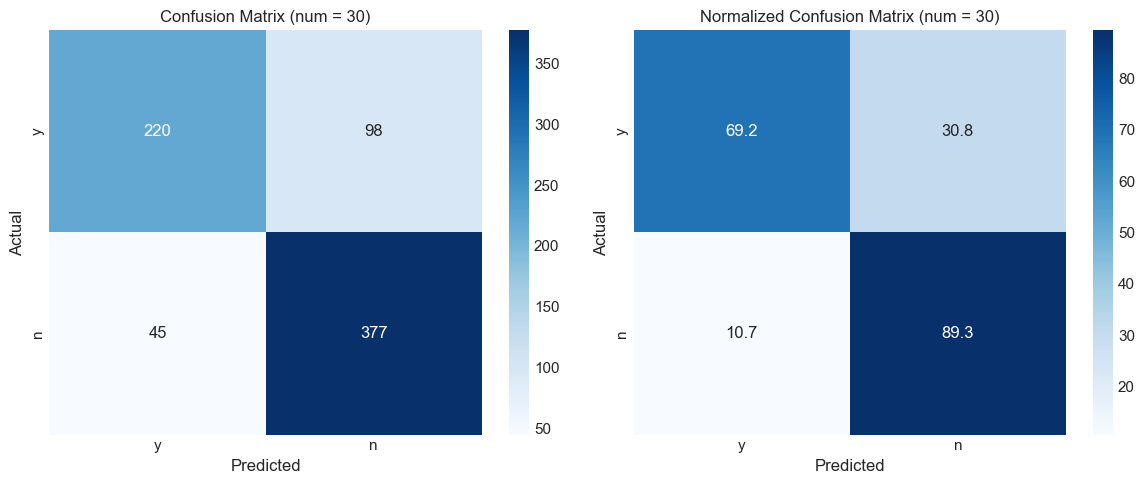

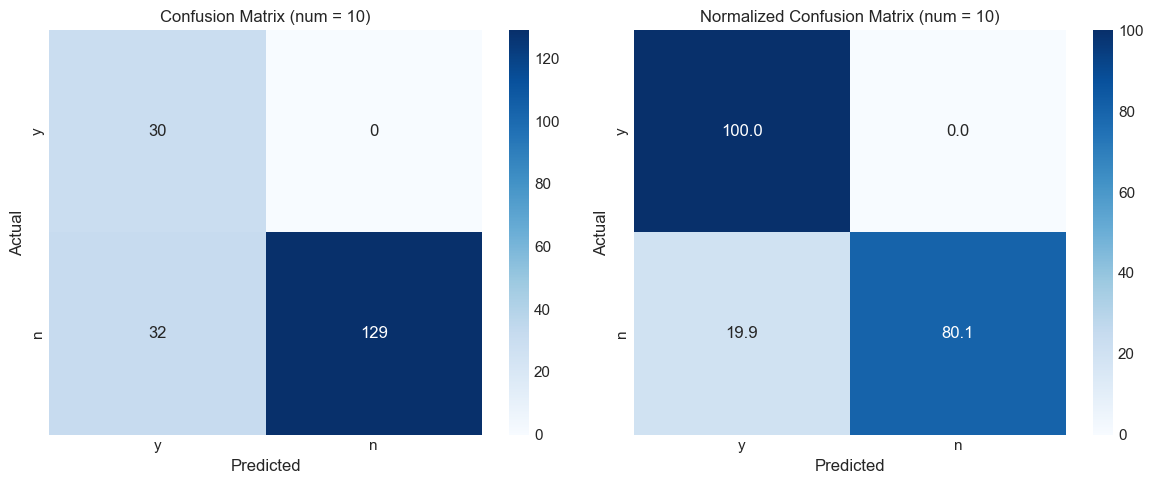

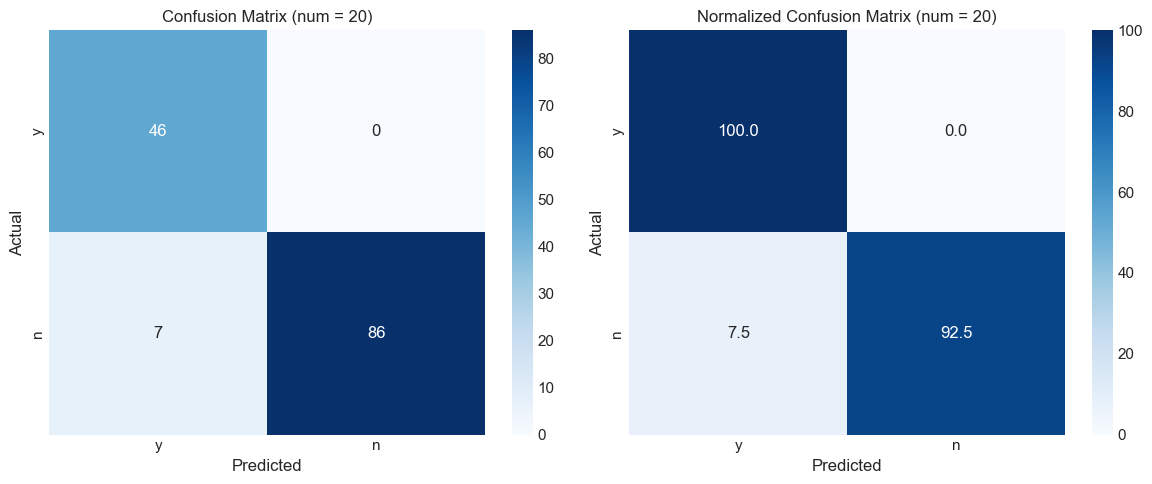

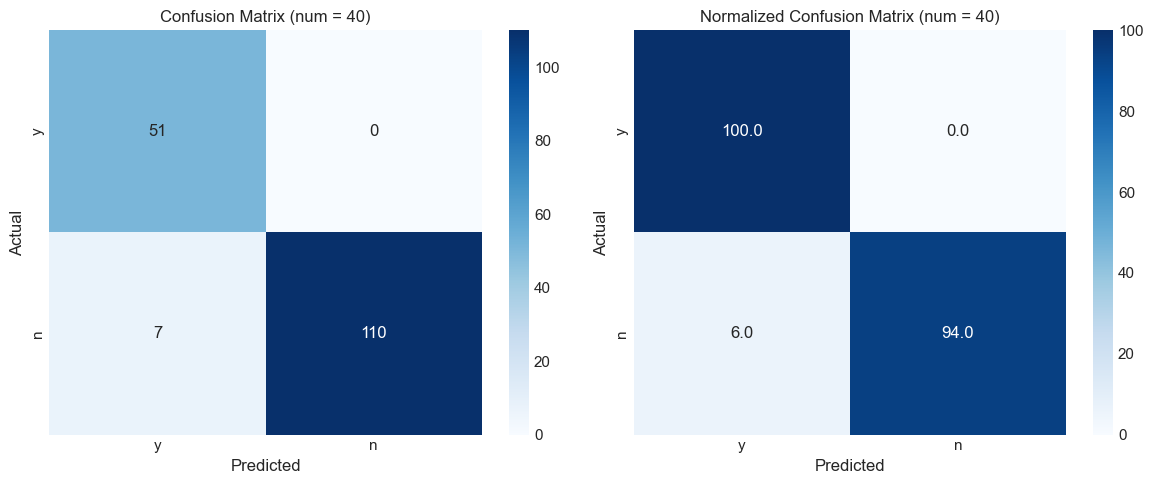

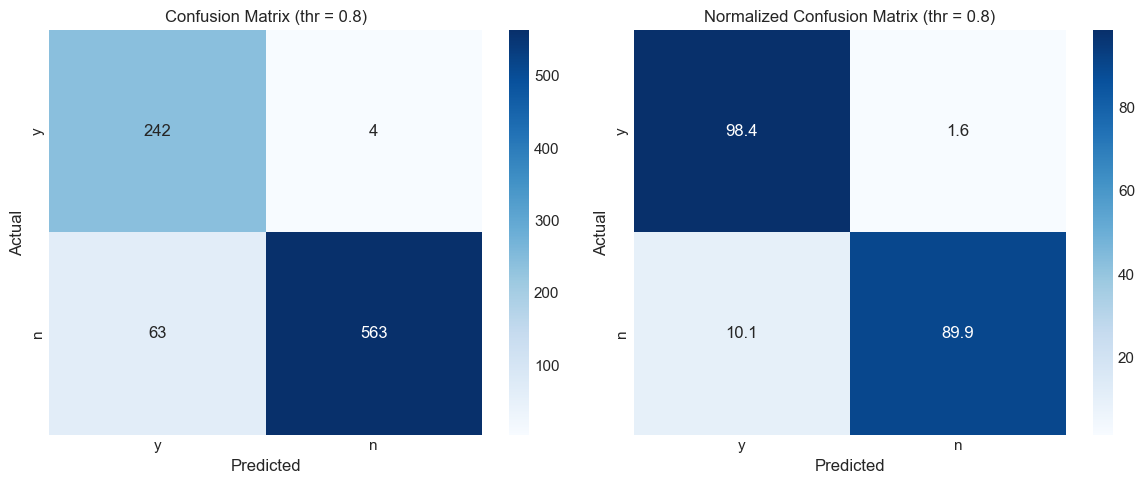

C:\Users\justa\AppData\Local\Temp\ipykernel_41052\3978108730.py:68: RuntimeWarning: invalid value encountered in divide
  norm_conf_mat = conf_mat / conf_mat.sum(axis=1, keepdims=True) * 100  # Normalized matrix as percentage


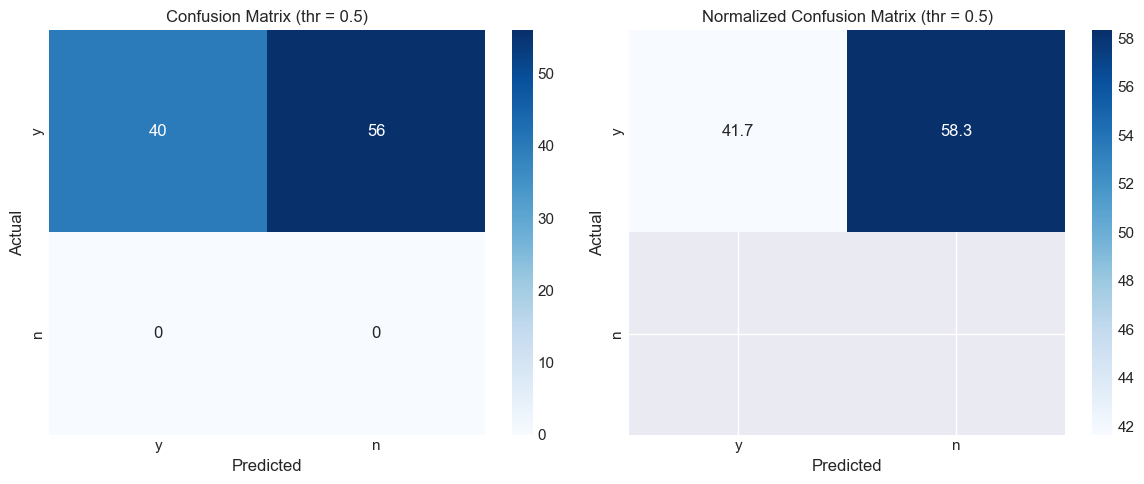

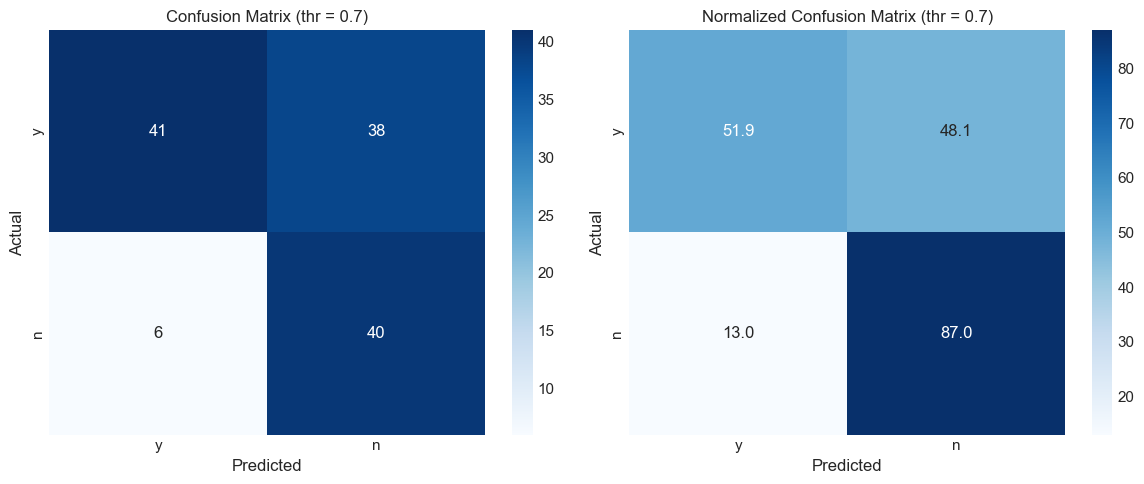

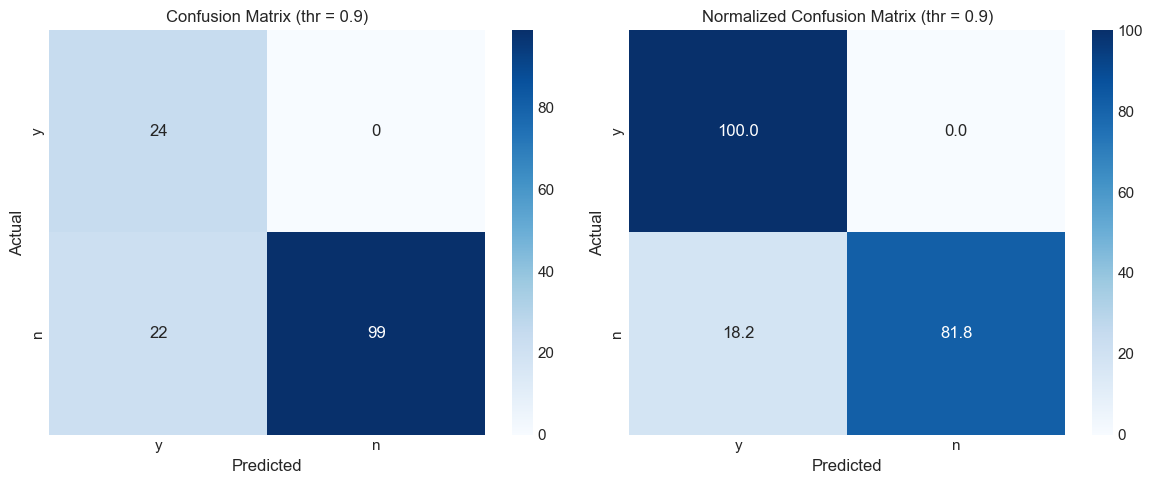

In [36]:
txt_dirs = ['ID_results/test_video1', 'ID_results/test_video2', 'ID_results/test_video3']
plt.style.use('seaborn-darkgrid')

# Initialize defaultdict of confusion matrices for each hyperparameter
d_confusion_matrices = defaultdict(lambda: np.zeros((2, 2)))
num_confusion_matrices = defaultdict(lambda: np.zeros((2, 2)))
thr_confusion_matrices = defaultdict(lambda: np.zeros((2, 2)))

# Loop over each directory
for txt_dir in txt_dirs:
    # List all files in directory
    txt_files = os.listdir(txt_dir)
    # Loop over each file
    for file_name in txt_files:
        # Check if file name follows expected format
        if 'd' in file_name and '_' in file_name and not file_name.endswith('_CORRECT.txt'):
            # Extract hyperparameters from file name
            params = file_name.split('d')[1].split('_')
            detection_confidence = float(params[0])
            num = int(params[1].replace('num', ''))
            thr = float(params[3].replace('thr', '').replace('.txt', ''))

            # Construct the name of the corresponding _CORRECT.txt file
            correct_file_name = file_name.rstrip('.txt') + '_CORRECT.txt'

            # Open the file and read its contents
            with open(os.path.join(txt_dir, file_name), 'r') as file:
                results = file.read().splitlines()

            # Open the correct results file and read its contents
            with open(os.path.join(txt_dir, correct_file_name), 'r') as file:
                correct_results = file.read().splitlines()

            # Count TP, TN, FP, and FN
            for i, j in zip(results, correct_results):
                if i == 'y' and j == 'y':
                    d_confusion_matrices[detection_confidence][0, 0] += 1
                    num_confusion_matrices[num][0, 0] += 1
                    thr_confusion_matrices[thr][0, 0] += 1
                elif i == 'y' and j == 'n':
                    d_confusion_matrices[detection_confidence][0, 1] += 1
                    num_confusion_matrices[num][0, 1] += 1
                    thr_confusion_matrices[thr][0, 1] += 1
                elif i == 'n' and j == 'y':
                    d_confusion_matrices[detection_confidence][1, 0] += 1
                    num_confusion_matrices[num][1, 0] += 1
                    thr_confusion_matrices[thr][1, 0] += 1
                elif i == 'n' and j == 'n':
                    d_confusion_matrices[detection_confidence][1, 1] += 1
                    num_confusion_matrices[num][1, 1] += 1
                    thr_confusion_matrices[thr][1, 1] += 1

# Plot the confusion matrices for each hyperparameter
for hyperparameter, matrices in [("d", d_confusion_matrices), 
                                 ("num", num_confusion_matrices), 
                                 ("thr", thr_confusion_matrices)]:
    for value, conf_mat in matrices.items():
        plt.figure(figsize=(12, 5))

        plt.subplot(121)
        conf_mat = conf_mat.astype(int)  # Cast to int before plotting
        sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues', xticklabels=['y', 'n'], yticklabels=['y', 'n'])
        plt.title(f'Confusion Matrix ({hyperparameter} = {value})')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        plt.subplot(122)
        norm_conf_mat = conf_mat / conf_mat.sum(axis=1, keepdims=True) * 100  # Normalized matrix as percentage
        sns.heatmap(norm_conf_mat, annot=True, fmt=".1f", cmap='Blues', xticklabels=['y', 'n'], yticklabels=['y', 'n'])  # Show one decimal place
        plt.title(f'Normalized Confusion Matrix ({hyperparameter} = {value})')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        plt.tight_layout()
        plt.show()


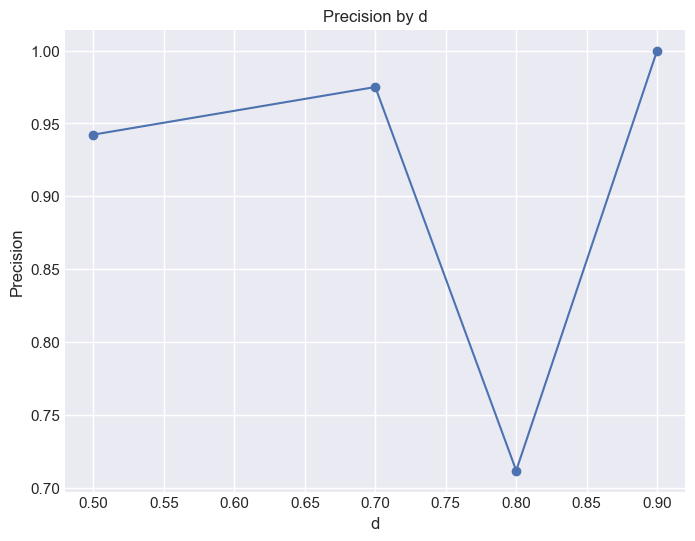

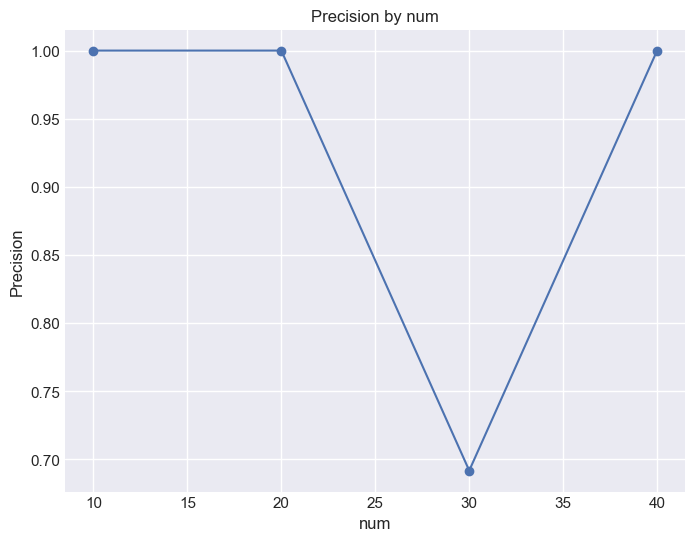

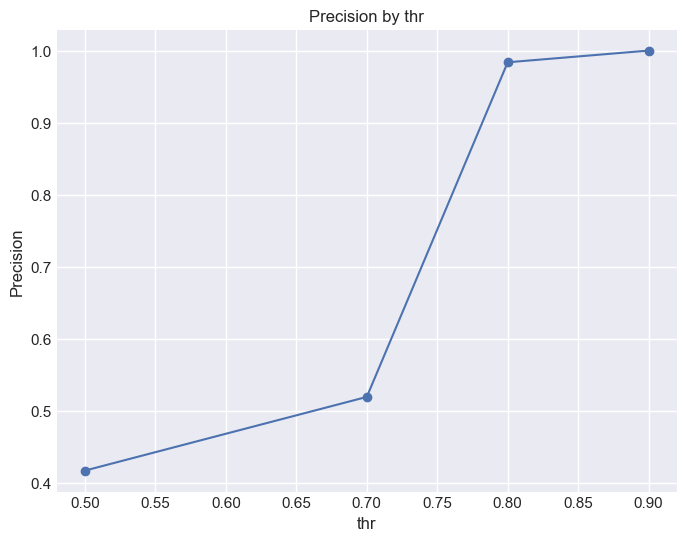

In [37]:
# Your existing code...

# Define a function to calculate precision
def calculate_precision(conf_mat):
    tp = conf_mat[0, 0]
    fp = conf_mat[0, 1]
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    return precision

# Initialize dictionaries to hold precision for each hyperparameter
d_precisions = {}
num_precisions = {}
thr_precisions = {}

# Calculate precision for each hyperparameter
for hyperparameter, matrices in [("d", d_confusion_matrices), 
                                 ("num", num_confusion_matrices), 
                                 ("thr", thr_confusion_matrices)]:
    for value, conf_mat in matrices.items():
        precision = calculate_precision(conf_mat)
        
        if hyperparameter == "d":
            d_precisions[value] = precision
        elif hyperparameter == "num":
            num_precisions[value] = precision
        elif hyperparameter == "thr":
            thr_precisions[value] = precision

# Plot precision for each hyperparameter
for hyperparameter, precisions in [("d", d_precisions), 
                                   ("num", num_precisions), 
                                   ("thr", thr_precisions)]:
    plt.figure(figsize=(8, 6))
    
    # Sort values for correct plotting
    values = sorted(precisions.items())
    x, y = zip(*values)  # Unzip values

    plt.plot(x, y, marker='o')
    plt.title(f'Precision by {hyperparameter}')
    plt.xlabel(hyperparameter)
    plt.ylabel('Precision')

    plt.show()


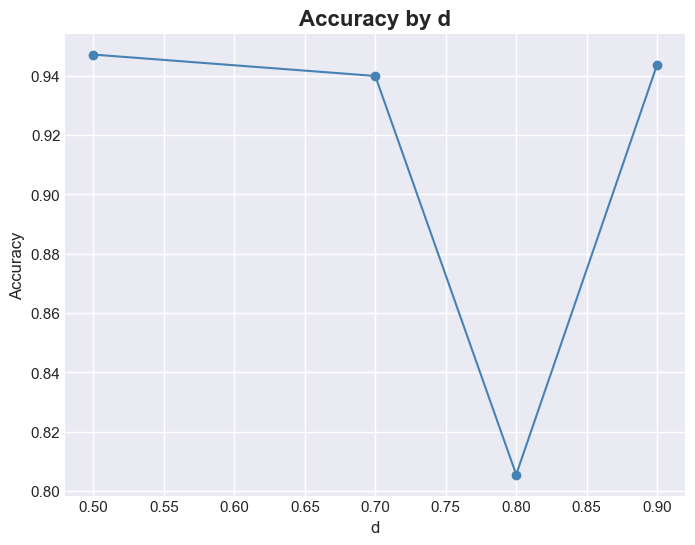

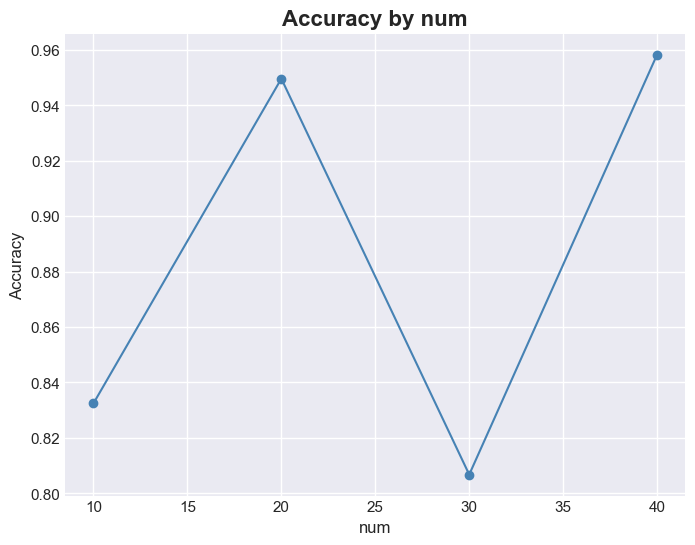

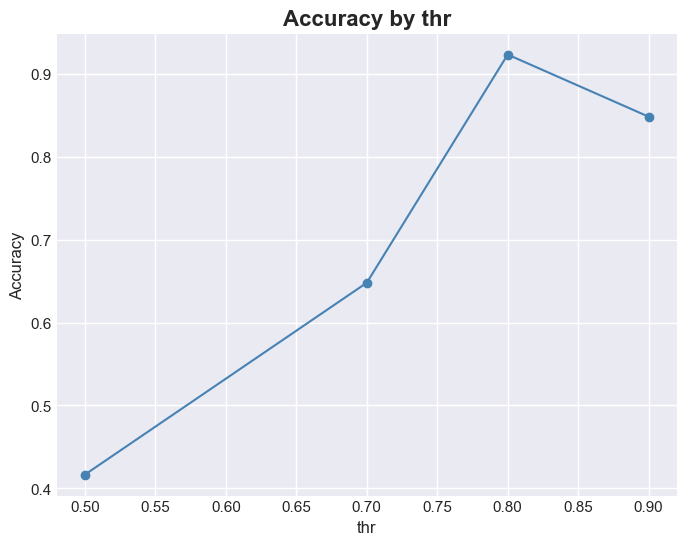

In [38]:
# Your existing code...

# Define a function to calculate accuracy
def calculate_accuracy(conf_mat):
    tp = conf_mat[0, 0]
    tn = conf_mat[1, 1]
    fp = conf_mat[0, 1]
    fn = conf_mat[1, 0]
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    return accuracy

# Initialize dictionaries to hold accuracy for each hyperparameter
d_accuracies = {}
num_accuracies = {}
thr_accuracies = {}

# Calculate accuracy for each hyperparameter
for hyperparameter, matrices in [("d", d_confusion_matrices), 
                                 ("num", num_confusion_matrices), 
                                 ("thr", thr_confusion_matrices)]:
    for value, conf_mat in matrices.items():
        accuracy = calculate_accuracy(conf_mat)
        
        if hyperparameter == "d":
            d_accuracies[value] = accuracy
        elif hyperparameter == "num":
            num_accuracies[value] = accuracy
        elif hyperparameter == "thr":
            thr_accuracies[value] = accuracy
# Set a style for matplotlib
# Plot accuracy for each hyperparameter
for hyperparameter, accuracies in [("d", d_accuracies), 
                                   ("num", num_accuracies), 
                                   ("thr", thr_accuracies)]:
    plt.figure(figsize=(8, 6))
    
    # Sort values for correct plotting
    values = sorted(accuracies.items())
    x, y = zip(*values)  # Unzip values

    # Create a line plot with markers
    plt.plot(x, y, marker='o', linestyle='-', color='steelblue')

    # Add title, labels and a grid
    plt.title(f'Accuracy by {hyperparameter}', fontsize=16, fontweight='bold')
    plt.xlabel(hyperparameter, fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.grid(True)

    # Show the plot
    plt.show()
